# Gradient correction analysis for DeepStarr

In [ ]:
!wget https://www.dropbox.com/s/g7guotjybwf6p6r/deepstarr_data.h5

--2022-08-12 00:09:50--  https://www.dropbox.com/s/g7guotjybwf6p6r/deepstarr_data.h5
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/g7guotjybwf6p6r/deepstarr_data.h5 [following]
--2022-08-12 00:09:50--  https://www.dropbox.com/s/raw/g7guotjybwf6p6r/deepstarr_data.h5
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0d4db4019734592db09050e81c.dl.dropboxusercontent.com/cd/0/inline/Bq24sJaiZNAPkFH9zP6liIjYWQibY6emQDvPJsbvUrLfcP3mZ-z-AlGzmAZ52j7FytCuv1hQpgp8zmGt2-qZdLb6mMMXxyNcjXBC8bSvIGq9PxP_ANCaMLGv_a2V77U2mih7dYBbPK5qQlmWxkKjrgYaPbxdVZPywOPSqRxgZi9LZQ/file# [following]
--2022-08-12 00:09:50--  https://uc0d4db4019734592db09050e81c.dl.dropboxusercontent.com/cd/0/inline/Bq24sJaiZNAPkFH9zP6liIjYWQibY6emQDvPJsbvUrLfcP3mZ-z-A

In [ ]:
!pip install logomaker
!pip install https://github.com/p-koo/tfomics/tarball/master

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 7.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     | 19 kB 3.0 MB/s
  Created wheel for tfomics: filename=tfomics-0.1.0.dev0-py3-none-any.whl size=23206 sha256=881bfffbf74f02e81e849d14f353fb2891fcea5f6368cbf7ab00aabddd606ba7
  Stored in directory: /tmp/pip-ephem-wheel-cache-e61sf8le/wheels/e1/eb/ae/f064df77529927df479c5f666c7572e25493375bcd4c1ff19f
Successfully built tfomics


In [ ]:
import os, h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import tfomics
import pandas as pd
import logomaker

In [ ]:
filepath = 'deepstarr_data.h5'
dataset = h5py.File(filepath, 'r')
x_train = np.array(dataset['x_train']).astype(np.float32)
y_train = np.array(dataset['y_train']).astype(np.float32).transpose()
x_valid = np.array(dataset['x_valid']).astype(np.float32)
y_valid = np.array(dataset['y_valid']).astype(np.float32).transpose()
x_test = np.array(dataset['x_test']).astype(np.float32)
y_test = np.array(dataset['y_test']).astype(np.float32).transpose()

# get shapes
N, L, A = x_valid.shape
num_labels = 2

print(x_train.shape)
print(y_test.shape)

(402296, 249, 4)
(41186, 2)


In [ ]:
from scipy.stats import spearmanr
def Spearman(y_true, y_pred):
     return ( tf.py_function(spearmanr, [tf.cast(y_pred, tf.float32), 
                       tf.cast(y_true, tf.float32)], Tout = tf.float32) )


def DeepSTARR(input_shape):

  inputs = keras.layers.Input(shape=input_shape)
  x = keras.layers.Conv1D(256, kernel_size=7, padding='same')(inputs)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Activation('exponential')(x)
  x = keras.layers.MaxPooling1D(2)(x)
  x = keras.layers.Dropout(0.1)(x)

  x = keras.layers.Conv1D(60, kernel_size=3, padding='same')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Activation('relu')(x)
  x = keras.layers.MaxPooling1D(2)(x)
  x = keras.layers.Dropout(0.1)(x)

  x = keras.layers.Conv1D(60, kernel_size=5, padding='same')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Activation('relu')(x)
  x = keras.layers.MaxPooling1D(2)(x)
  x = keras.layers.Dropout(0.1)(x)

  x = keras.layers.Conv1D(120, kernel_size=3, padding='same')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Activation('relu')(x)
  x = keras.layers.MaxPooling1D(2)(x)
  x = keras.layers.Dropout(0.1)(x)

  x = keras.layers.Flatten()(x)

  x = keras.layers.Dense(256)(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Activation('relu')(x)
  x = keras.layers.Dropout(0.4)(x)

  x = keras.layers.Dense(256)(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Activation('relu')(x)
  x = keras.layers.Dropout(0.4)(x)

  outputs = keras.layers.Dense(2, activation='linear')(x)

  return inputs, outputs


keras.backend.clear_session()


tasks = ['Dev','Hk']

inputs, outputs = DeepSTARR(input_shape=(L,A))


model = keras.Model(inputs=inputs, outputs=outputs)

# set up optimizer and metrics
model.compile(keras.optimizers.Adam(learning_rate=0.0003),
              loss='mse',
              #loss_weights=[1, 1], # loss weights to balance
              metrics=[Spearman]) # additional track metric

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 249, 4)]          0         
                                                                 
 conv1d (Conv1D)             (None, 249, 256)          7424      
                                                                 
 batch_normalization (BatchN  (None, 249, 256)         1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 249, 256)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 124, 256)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 124, 256)          0     

In [ ]:

# early stopping callback
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', #'val_aupr',#
                                            patience=10, 
                                            verbose=1, 
                                            mode='min', 
                                            restore_best_weights=True)
# reduce learning rate callback
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                factor=0.2,
                                                patience=3, 
                                                min_lr=1e-7,
                                                mode='min',
                                                verbose=1) 

# train model
history = model.fit(x_train, y_train, 
                    epochs=100,
                    batch_size=64, 
                    shuffle=True,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[es_callback, reduce_lr])

Epoch 1/100
6286/6286 [==============================] - 104s 15ms/step - loss: 2.0967 - Spearman: 0.5346 - val_loss: 1.6354 - val_Spearman: 0.5862 - lr: 3.0000e-04
Epoch 2/100
6286/6286 [==============================] - 90s 14ms/step - loss: 1.6299 - Spearman: 0.6145 - val_loss: 1.4770 - val_Spearman: 0.6021 - lr: 3.0000e-04
Epoch 3/100
6286/6286 [==============================] - 89s 14ms/step - loss: 1.5391 - Spearman: 0.6245 - val_loss: 1.4669 - val_Spearman: 0.6021 - lr: 3.0000e-04
Epoch 4/100
6286/6286 [==============================] - 89s 14ms/step - loss: 1.4924 - Spearman: 0.6296 - val_loss: 1.4179 - val_Spearman: 0.6071 - lr: 3.0000e-04
Epoch 5/100
6286/6286 [==============================] - 89s 14ms/step - loss: 1.4561 - Spearman: 0.6327 - val_loss: 1.3666 - val_Spearman: 0.6101 - lr: 3.0000e-04
Epoch 6/100
6286/6286 [==============================] - 89s 14ms/step - loss: 1.4269 - Spearman: 0.6361 - val_loss: 1.3229 - val_Spearman: 0.6085 - lr: 3.0000e-04
Epoch 7/100
628

In [ ]:
results = model.evaluate(x_test, y_test)

1288/1288 [==============================] - 8s 6ms/step - loss: 1.2437 - Spearman: 0.6192


In [ ]:
from scipy import stats
from sklearn.metrics import mean_squared_error

# create functions
def summary_statistics(model, X, Y, set, task):
    pred = model.predict(X, batch_size=512)
    if task =="Dev":
        i=0
    if task =="Hk":
        i=1
    print(set + ' MSE ' + task + ' = ' + str("{0:0.2f}".format(mean_squared_error(Y[:,i], pred[:,i]))))
    print(set + ' PCC ' + task + ' = ' + str("{0:0.2f}".format(stats.pearsonr(Y[:,i], pred[:,i])[0])))
    print(set + ' SCC ' + task + ' = ' + str("{0:0.2f}".format(stats.spearmanr(Y[:,i], pred[:,i])[0])))
    
# run for each set and enhancer type
summary_statistics(model, x_test,  y_test, "test", "Dev")
summary_statistics(model, x_test,  y_test, "test", "Hk")


test MSE Dev = 1.25
test PCC Dev = 0.68
test SCC Dev = 0.66
test MSE Hk = 1.23
test PCC Hk = 0.76
test SCC Hk = 0.58


In [ ]:
from scipy import stats
from sklearn.metrics import mean_squared_error

# create functions
def summary_statistics(model, X, Y, set, task):
    pred = model.predict(X, batch_size=512)
    if task =="Dev":
        i=0
    if task =="Hk":
        i=1
    print(set + ' MSE ' + task + ' = ' + str("{0:0.2f}".format(mean_squared_error(Y[:,i], pred[:,i]))))
    print(set + ' PCC ' + task + ' = ' + str("{0:0.2f}".format(stats.pearsonr(Y[:,i], pred[:,i])[0])))
    print(set + ' SCC ' + task + ' = ' + str("{0:0.2f}".format(stats.spearmanr(Y[:,i], pred[:,i])[0])))
    
# run for each set and enhancer type
summary_statistics(model, x_test,  y_test, "test", "Dev")
summary_statistics(model, x_test,  y_test, "test", "Hk")


test MSE Dev = 1.28
test PCC Dev = 0.68
test SCC Dev = 0.65
test MSE Hk = 1.25
test PCC Hk = 0.75
test SCC Hk = 0.57


In [ ]:
#model.load_weights('deepstarr_replicate.h5')
#model.load_weights('deepstarr_exp.h5')

# Gradient angle analysis of saliency maps

In [ ]:
from tfomics import explain

def calculate_angles(saliency_score):
  orthogonal_residual = np.sum(saliency_score, axis=-1)
  L2_norm = np.sqrt(np.sum(np.square(saliency_score), axis=-1))
  sine = 1/2 * orthogonal_residual / L2_norm 
  sine = np.arcsin(sine) * (180/3.1416) 
  return sine


# instantiate explainer class
explainer = explain.Explainer(model, func=tf.math.reduce_max, class_index=0)

# calculate attribution maps
num_data = 41186
saliency_scores0 = explainer.saliency_maps(x_test[:num_data])

# calculate angles
angles0 = calculate_angles(saliency_scores0)
angles0_flat = np.reshape(angles0, [-1,])

# instantiate explainer class
explainer = explain.Explainer(model, func=tf.math.reduce_max, class_index=1)

# calculate attribution maps
saliency_scores1 = explainer.saliency_maps(x_test[:num_data])

# calculate angles
angles1 = calculate_angles(saliency_scores1)
angles1_flat = np.reshape(angles1, [-1,])


## Angle Histogram plot

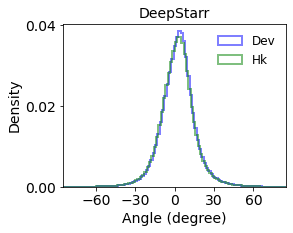

In [ ]:

fig = plt.figure(figsize=(4,3))
plt.hist(angles0_flat, 100, density=True, alpha=0.5, color='b', histtype='step', linewidth=2)
plt.hist(angles1_flat, 100, density=True, alpha=0.5, color='g', histtype='step', linewidth=2)
plt.ylabel('Density', fontsize=14)
plt.xlabel('Angle (degree)', fontsize=14)
plt.title('DeepStarr', fontsize=14)
plt.xticks([-60, -30, 0, 30, 60], fontsize=14)
#plt.tick_params(axis='x',  which='both', bottom=False,  top=False, labelbottom=False) 
plt.yticks(ticks=[0.0, 0.02, 0.04], fontsize=14)
plt.xlim([-85, 85])
plt.legend(tasks, fontsize=12, frameon=False)
fig.savefig('deepstarr_exp_angle_hist.pdf', format='pdf', dpi=200, bbox_inches='tight')


## Visualize sequence logos 

In [ ]:

def plot_attribution_map(saliency_df, ax=None, figsize=(20,1), fontsize=16):
  """plot an attribution map using logomaker"""

  logomaker.Logo(saliency_df, figsize=figsize, ax=ax)
  if ax is None:
    ax = plt.gca()
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.yaxis.set_ticks_position('none')
  ax.xaxis.set_ticks_position('none')
  ax.tick_params(axis="x", labelsize=fontsize)
  ax.tick_params(axis="y", labelsize=fontsize)
  plt.xticks([])


def plot_angle_logo(angles, ax=None, figsize=(20,1), fontsize=16):
  L = len(angles)
  counts_df = pd.DataFrame(data=0.0, columns=list('∧'), index=list(range(L)))
  for l in range(L):
    counts_df.iloc[l,0] = angles[l]

  logomaker.Logo(counts_df, figsize=figsize, ax=ax)  
  if ax is None:
      ax = plt.gca()
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.xaxis.set_ticks_position('none')
  plt.xticks([])
  ax.set_ylabel('Angle', fontsize=fontsize)
  ax.tick_params(axis="x", labelsize=fontsize)
  ax.tick_params(axis="y", labelsize=fontsize)


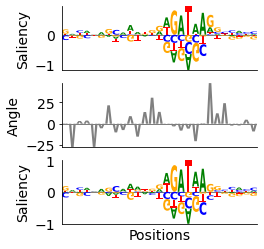

In [ ]:
index = 27853

plot_range = range(17,44)
X = np.expand_dims(x_test[index], axis=0)
sal_scores = np.expand_dims(saliency_scores0[index], axis=0)

sal_scores_correct = sal_scores - np.mean(sal_scores, axis=2, keepdims=True)

saliency_df = tfomics.impress.matrix_to_df(X, sal_scores[0,plot_range,:])
saliency_df2 = tfomics.impress.matrix_to_df(X, sal_scores_correct[0,plot_range,:])

fig = plt.figure(figsize=(3.5,4))
ax = plt.subplot(3,1,1)
plot_attribution_map(saliency_df, ax, figsize=(20,1), fontsize=14)
ax.set_ylabel('Saliency', fontsize=14)
ax = plt.subplot(3,1,2)
plot_angle_logo(angles0[index][plot_range], ax, figsize=(20,1), fontsize=14)
ax = plt.subplot(3,1,3)
plot_attribution_map(saliency_df2, ax, figsize=(20,1), fontsize=14) 
ax.set_ylabel('Saliency', fontsize=14)
ax.set_xlabel('Positions', fontsize=14)
fig.savefig('deepstarr_exp_27853.pdf', format='pdf', dpi=200, bbox_inches='tight')


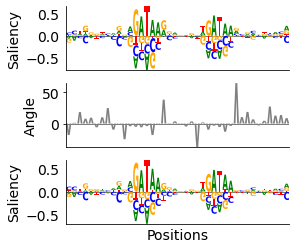

In [ ]:
index = 36601

plot_range = range(20,60)
X = np.expand_dims(x_test[index], axis=0)
sal_scores = np.expand_dims(saliency_scores0[index], axis=0)

sal_scores_correct = sal_scores - np.mean(sal_scores, axis=2, keepdims=True)

saliency_df = tfomics.impress.matrix_to_df(X, sal_scores[0,plot_range,:])
saliency_df2 = tfomics.impress.matrix_to_df(X, sal_scores_correct[0,plot_range,:])

fig = plt.figure(figsize=(4,4))
ax = plt.subplot(3,1,1)
plot_attribution_map(saliency_df, ax, figsize=(20,1), fontsize=14)
ax.set_ylabel('Saliency', fontsize=14)
ax = plt.subplot(3,1,2)
plot_angle_logo(angles0[index][plot_range], ax, figsize=(20,1), fontsize=14)
ax = plt.subplot(3,1,3)
plot_attribution_map(saliency_df2, ax, figsize=(20,1), fontsize=14) 
ax.set_ylabel('Saliency', fontsize=14)
ax.set_xlabel('Positions', fontsize=14)
fig.savefig('deepstarr_exp_36601.pdf', format='pdf', dpi=200, bbox_inches='tight')



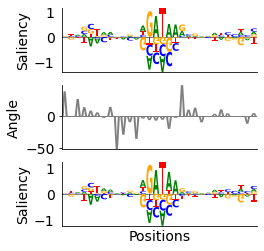

In [ ]:
index = 40960

plot_range = range(30)
X = np.expand_dims(x_test[index], axis=0)
sal_scores = np.expand_dims(saliency_scores0[index], axis=0)

sal_scores_correct = sal_scores - np.mean(sal_scores, axis=2, keepdims=True)

saliency_df = tfomics.impress.matrix_to_df(X, sal_scores[0,plot_range,:])
saliency_df2 = tfomics.impress.matrix_to_df(X, sal_scores_correct[0,plot_range,:])

fig = plt.figure(figsize=(3.5,4))
ax = plt.subplot(3,1,1)
plot_attribution_map(saliency_df, ax, figsize=(20,1), fontsize=14)
ax.set_ylabel('Saliency', fontsize=14)
ax = plt.subplot(3,1,2)
plot_angle_logo(angles0[index][plot_range], ax, figsize=(20,1), fontsize=14)
ax = plt.subplot(3,1,3)
plot_attribution_map(saliency_df2, ax, figsize=(20,1), fontsize=14) 
ax.set_ylabel('Saliency', fontsize=14)
ax.set_xlabel('Positions', fontsize=14)
fig.savefig('deepstarr_exp_40960.pdf', format='pdf', dpi=200, bbox_inches='tight')

